Let's make a metric that lets us quantify the uncertainty in a shape measured off a serries of images

For the systematic. It might make sense to assume a perfectly circular object, then compute the SNR on a systematic effect, say, a stretch in the x-dimension. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.photUtils import Sed, Bandpass


In [29]:
class Phot_properties(object):
    """Object to hold handy values mostly calculated in sys-eng throughputs
    """
    
    def __init__(self):
        # Calculate dust extinction values
        waveMins = {'u':330.,'g':403.,'r':552.,'i':691.,'z':818.,'y':950.}
        waveMaxes = {'u':403.,'g':552.,'r':691.,'i':818.,'z':922.,'y':1070.}
        self.Ax1 = {}
        for filtername in waveMins:
            wavelen_min = waveMins[filtername]
            wavelen_max = waveMaxes[filtername]
            testsed = Sed()
            testsed.setFlatSED(wavelen_min=wavelen_min, wavelen_max=wavelen_max, wavelen_step=1.0)
            testbandpass = Bandpass(wavelen_min=wavelen_min, wavelen_max=wavelen_max, wavelen_step=1.0)
            testbandpass.setBandpass(wavelen=testsed.wavelen,
                                     sb=np.ones(len(testsed.wavelen)))
            self.R_v = 3.1
            self.ref_ebv = 1.0
            # Calculate non-dust-extincted magnitude
            flatmag = testsed.calcMag(testbandpass)
            # Add dust
            self.a, self.b = testsed.setupCCM_ab()
            testsed.addDust(self.a, self.b, ebv=self.ref_ebv, R_v=self.R_v)
            # Calculate difference due to dust when EBV=1.0 (m_dust = m_nodust - Ax, Ax > 0)
            self.Ax1[filtername] = testsed.calcMag(testbandpass) - flatmag
            
        # Telescope zeropoint for 30s exposure
        self.zp = {'u': 27.03, 'g':28.38 , 'r':28.15 , 'i':27.86 , 'z':27.46 ,'y':26.68}
        # Atmospheric extinction coefficents
        self.kAtm = {'u': 0.502, 'g': 0.214, 'r': 0.126, 'i': 0.096, 'z': 0.069 ,'y': 0.169}
        self.exptime = 30.
        self.pixscale = 0.2
        

In [32]:
class Size_precision_metric(metrics.BaseMetric):
    """
    
    Parameters
    ----------
    pixscale : float (0.2)
        The pixelscale of the CCD, arsec/pix (0.2).
    fwhm_object : float (3.)
        The FWHM of the fiducial object who's shape is being measured, arcseconds (3.).
    mu_0_object : dict-like
        Dictionary with keys of filternames and values of the central surface brightness of an object.
        
    stellar_density_limit : float (None)
        XXX--to add, put in a limit where if the stellar density is too high, returns weight of 0.
    
    """
    
    def __init__(self,seeingCol='seeingFwhmGeom', metricName=None,
                 fwhm_object=3., mu_0_object={'g': 19., 'r': 19., 'i': 19.},
                 stellar_density_limit=None,
                 filterCol='filter', stellar_ref_peak={'g': 5000., 'r': 5000., 'i': 5000.},
                 m5Col='fiveSigmaDepth', exptimeCol='visitExposureTime',
                 skyCol='skyBrightness', airmassCol='airmass',
                 maps=['StellarDensityMap', 'DustMap'],
                 return_weights=False, phot_parameters=None, **kwargs):
        self.seeingCol = seeingCol
        self.m5Col = m5Col
        self.fwhm_object = fwhm_object
        self.mu_0_object = mu_0_object
        self.filterCol = filterCol
        self.exptimeCol = exptimeCol
        self.return_weights = return_weights
        self.stellar_ref_peak = stellar_ref_peak
        self.skyCol = skyCol
        self.airmassCol = airmassCol
        cols =[seeingCol, m5Col, filterCol, exptimeCol, skyCol, airmassCol]
        units = 'arcsec'
        super().__init__(col=cols, maps=maps, units=units, metricName=metricName, **kwargs)
        
        if phot_parameters is None:
            self.phot_parameters = Phot_properties()
        else:
            self.phot_parameters = phot_parameters

        
        # XXX--could declare a stellar density limit and mask out healpixels where things get too crowded
        
        
    def run(self, dataSlice, slicePoint=None):
        peak_counts = dataSlice[self.seeingCol]*0
        noise_at_peak = dataSlice[self.seeingCol]*0+1e6
        star_fwhm = dataSlice[self.seeingCol]
        sigma_fwhm_refstar = dataSlice[self.seeingCol]*0
        for filtername in self.mu_0_object:
            in_filt = np.where(dataSlice[self.filterCol] == filtername)
            
            
            #  Apply dust extinction to the peak flux
            A_x = self.phot_parameters.Ax1[filtername] * slicePoint['ebv']
            mu_0 = self.mu_0_object[filtername] + A_x
            # Scale mu_0 by exposure time
            mu_0 += 1.25*np.log(dataSlice[self.exptimeCol][in_filt]/self.phot_parameters.exptime)
            # Apply airmass extinction to the peak fluxes
            mu_0 += self.phot_parameters.kAtm[filtername]*(dataSlice[self.airmassCol][in_filt] - 1.0)
            # XXX--apply seeing correction to peak fluxes
            
            # convert central surface brightness to counts
            peak_counts_sqdeg = 10.**(0.4*(self.phot_parameters.zp[filtername] - mu_0))
            peak_counts[in_filt] = peak_counts_sqdeg * self.phot_parameters.pixscale**2
            # I think this is how you can go from surface brightness to counts per sq degree?
            sky_counts_sqdeg = 10.**(0.4*(self.phot_parameters.zp[filtername] - dataSlice[self.skyCol][in_filt]))
            sky_counts = sky_counts_sqdeg * self.phot_parameters.pixscale**2
            # Assuming sky or source dominating the noise
            noise_at_peak[in_filt] = (sky_counts + peak_counts[in_filt])**0.5
            
            # compute the uncertainty in the shape of a psf from a star on the image. Not going to bother with dust and airamss on this
            sigma_fwhm_refstar[in_filt] = 1.4*star_fwhm[in_filt]*(self.phot_parameters.pixscale/star_fwhm[in_filt])**0.5*noise_at_peak[in_filt]/self.stellar_ref_peak[filtername]
        
        # Let's use the simple equation from: http://articles.adsabs.harvard.edu//full/1992PASP..104.1104L/0001105.000.html
        # to say what the uncertainty in the shape we measure is.
        # the observed FWHM is convolved with the seeing. Should probably also define a fiducial seeing and 
        # factor that up/down depending on the actual seeing
        fwhm_observed = np.sqrt(self.fwhm_object**2 + dataSlice[self.seeingCol]**2)
        sigma_fwhm_object_predeconv = 1.4*fwhm_observed*(self.phot_parameters.pixscale/fwhm_observed)**0.5*noise_at_peak/peak_counts
        
        
        
        # Uncertainty in reference star PSF can dominate 
        sigma_fwhm_object = (sigma_fwhm_object_predeconv**2 + sigma_fwhm_refstar**2)**0.5
        if self.return_weights:
            return 1./sigma_fwhm_object**2
        else:
            result = np.sum(1./sigma_fwhm_object**2)**-0.5 # xxx-Maybe return this as an SNR so larger is better?
            return result
        
class Systematic_angle_metric(metrics.BaseMetric):
    """Compute how strongly systematics are canceled in a series of shape observations
    """
    
    def __init__(self, angleCol='rotTelPos', mod=180., shape_metric=None,
                 **kwargs):
        if shape_metric is None:
            self.shape_metric = Shape_precision_metric(return_weights=True, **kwargs)
        
        self.mod = np.radians(mod)
        self.angleCol = angleCol
        super().__init__(col=cols, maps=maps, units=units, metricName=metricName, **kwargs)
        
    def run(self, dataSlice, slicepoint=None):
        weights = self.shape_metric(dataSlice, slicepoint=slicePoint)
        angles = dataSlice[self.angleCol] % self.mod
        # Could maybe broadcast with a phase vector
        # Suppose I have a galaxy with major axis a along the x-axis, and minor axis b along y axis
        # when angle=0. If there is a distortion along the x-axis, no shape distortion when angle=45 deg.
        a_stretch = np.abs(np.cos(angles))
        b_stretch = np.abs(np.sin(angles))
        # Compute the weighted mean
        shape_wmean = np.sum((1.+a_stretch)/(1.+b_stretch)*weights)/np.sum(weights)
        
        # systematic remaining in shape measurement. 0 means perfectly canceled, 1 means 
        # no systematic was removed. Might need a factor of 2 if I do a phase scan.
        return 1. - shape_wmean
        
        
    

In [3]:
## Suppose we have an object with an axial ratio of 2/1
a=2.
b=1.

theta = np.radians(np.arange(0,360.,1))

a_x = a*np.cos(theta)
a_y = a*np.sin(theta)

b_x = b*np.sin(theta)
b_y = b*np.cos(theta)

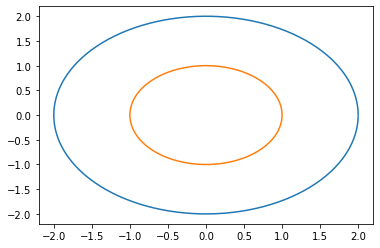

In [4]:
plt.plot(a_x, a_y)
plt.plot(b_x, b_y)

In [5]:
# Now we introduce a systematic that distorts the x-axis to be 5% larger than it should be
d=1.05
a_dx = a_x*d
b_dx = b_x*d

In [6]:
a_d = (a_dx**2+a_y**2)**.5
b_d = (b_dx**2+b_y**2)**.5

Text(0, 0.5, 'a/b (should be 2)')

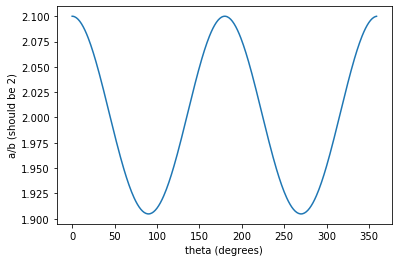

In [7]:
plt.plot(np.degrees(theta), a_d/b_d)
plt.xlabel('theta (degrees)')
plt.ylabel('a/b (should be 2)')

In [8]:
# So, fitting a sin wave of unknown phase. I think the best way would be to check 1) is the phase coverage adequate and 
# 2) what would be the uncertainty on the amplitude say, if everything was at amplitude 1/2, since that's what it would be on average


In [9]:
dbFile = 'baseline_nexp2_v1.7_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [33]:
bundleList = []
sql = ''
metric = Size_precision_metric()
slicer = slicers.HealpixSlicer(useCache=False)
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with no constraint for columns ['airmass', 'visitExposureTime', 'fiveSigmaDepth', 'fieldDec', 'seeingFwhmGeom', 'filter', 'fieldRA', 'skyBrightness'].
Found 2045493 visits
Running:  ['opsim_Size_precision_metric_seeingFwhmGeom_fiveSigmaDepth_filter_visitExposureTime_skyBrightness_airmass_HEAL']


/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in double_scalars
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in square


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/image.py:401: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 417696799333703761211715970486049504046202765224396004322672100769139597692299471108301349978112 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 9.57256e+86  dipole: lon: -88.2426, lat: 18.0765, amp: 1.90165e+87
  mono, lon, lat, amp


Plotting complete.


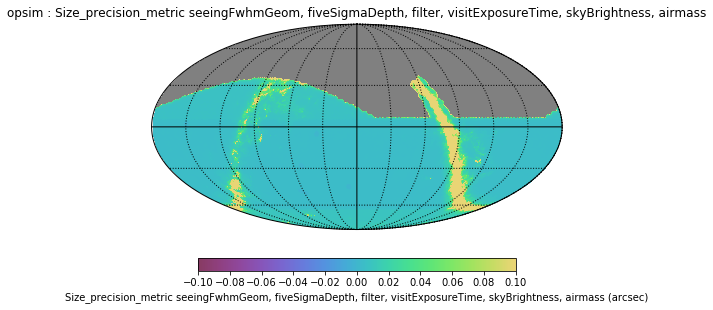

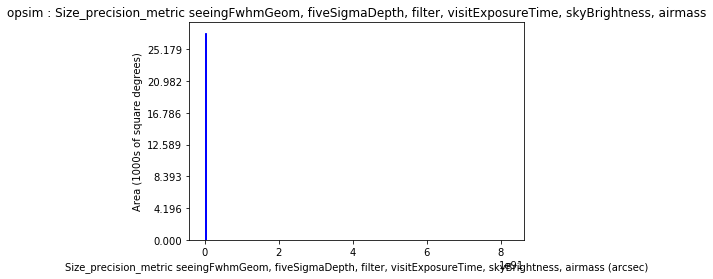

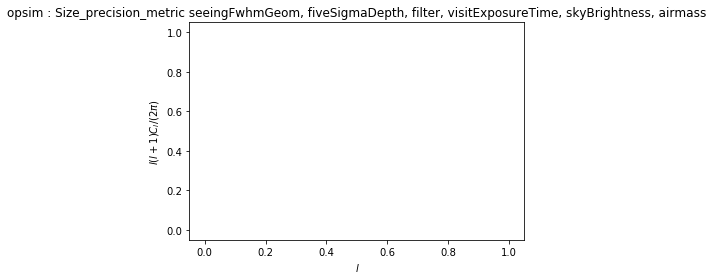

In [34]:
bg.plotAll(closefigs=False)

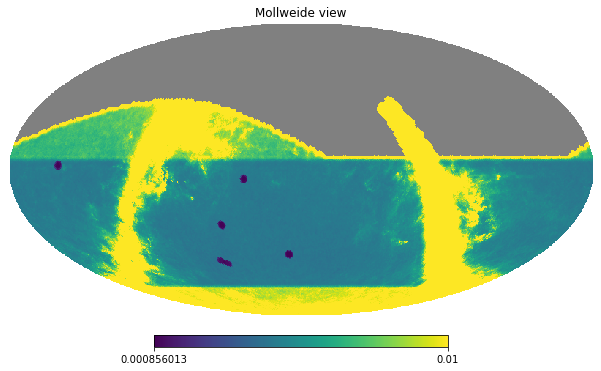

In [35]:
hp.mollview(bundleList[0].metricValues, max=1e-2)